<a href="https://colab.research.google.com/github/Chandan-Kumar-Vanamala/k1/blob/main/Brain_Tumor_Detection_3_0_vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install torchnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 72.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 7.4 MB/s eta 0:00:00
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29745 sha256=0f4545bd292d7787fe80fecedd44b435771ff43af8df137e27629987816b93de
  Stored in directory: /root/.cache/pip/wheels/65/d2/1e/0c2519d1837089fe374a60ce10e120c555b9d77110a49f027f
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408216 sha256=60783bf7585cb4592032dbdf0c990c5e1de6aca13f2ab8623fbe58e7cd751127
  Stored in directory: /root/.cache/pip/wheels/58/9e/14/30f7cc4dafdd4d602fb00ca33c6edd1424fc0f5df10a02e060
Successfully built torchnet visdom


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import seaborn as sn
import pandas as pd
import torchnet.meter.confusionmeter as cm

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation & test
data_transforms = {
    'Training': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Validating': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Testing': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224) ,
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ])
}


In [ ]:
data_dir = '/content/gdrive/MyDrive/Brain_Tumor_Detection_3.0/Contrast_dataset_final'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['Testing','Training', 'Validating']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['Testing','Training', 'Validating']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['Testing','Training', 'Validating']}
class_names = image_datasets['Training'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(class_names)

cuda:0
['glioma', 'meningioma', 'notumor', 'pituitory']


In [ ]:
#lists for graph generation
epoch_counter_train = []
epoch_counter_val = []
train_loss = []
val_loss = []
train_acc = []
val_acc = []

#Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    print(since)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    epoch_no = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['Training', 'Testing']:
            if phase == 'Training':
                # scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'Training'):  
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    probs = torch.exp(outputs) 
                    # print(probs)
                    # print(_)
                    # print(preds)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'Training':
                        loss.backward()
                        optimizer.step()

                # statistics 
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            #For graph generation
            if phase == "Training":
                train_loss.append(running_loss/dataset_sizes[phase])
                train_acc.append(running_corrects.double() / dataset_sizes[phase])
                epoch_counter_train.append(epoch)
            if phase == "Testing":
                val_loss.append(running_loss/ dataset_sizes[phase])
                val_acc.append(running_corrects.double() / dataset_sizes[phase]) 
                epoch_counter_val.append(epoch)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #for printing        
            if phase == "Training":    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == "Testing":    
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the best model
            if phase == 'Testing' and epoch_acc > best_acc:
                best_acc = epoch_acc
                epoch_no = epoch
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f} in epoch {}'.format(best_acc, epoch_no))

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), '/content/gdrive/MyDrive/Brain_Tumor_Detection_3.0/Model/vgg19softmax1.pt')
    return model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


# Define the device to be used
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the model architecture
model_ft = models.vgg19_bn(pretrained=True)
# Get the number of input features to the final layer
num_ftrs = model_ft.classifier[-1].in_features

# Replace the final layer with a new one
model_ft.classifier[-1] = nn.Linear(num_ftrs, 4)

# Add LogSoftmax activation to the output layer
model_ft.classifier.add_module('output', nn.LogSoftmax(dim=1))

# Move the model to the device
model = model_ft.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer with weight decay
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=0.0001)

# Define the learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [ ]:
import torch
print(torch.version.cuda)

11.6


In [ ]:
# Train the model
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=60)

1680435016.125062
Epoch 1/60
----------
Training Loss: 0.5216 Acc: 0.8083
Testing Loss: 0.4115 Acc: 0.8520

Epoch 2/60
----------
Training Loss: 0.4492 Acc: 0.8316
Testing Loss: 0.3570 Acc: 0.8696

Epoch 3/60
----------
Training Loss: 0.4080 Acc: 0.8498
Testing Loss: 0.3112 Acc: 0.8879

Epoch 4/60
----------
Training Loss: 0.3738 Acc: 0.8573
Testing Loss: 0.2764 Acc: 0.8932

Epoch 5/60
----------
Training Loss: 0.3450 Acc: 0.8718
Testing Loss: 0.2472 Acc: 0.9077

Epoch 6/60
----------
Training Loss: 0.3178 Acc: 0.8766
Testing Loss: 0.2270 Acc: 0.9184

Epoch 7/60
----------
Training Loss: 0.2972 Acc: 0.8880
Testing Loss: 0.2051 Acc: 0.9237

Epoch 8/60
----------
Training Loss: 0.2882 Acc: 0.8930
Testing Loss: 0.2064 Acc: 0.9214

Epoch 9/60
----------
Training Loss: 0.2706 Acc: 0.8967
Testing Loss: 0.1825 Acc: 0.9268

Epoch 10/60
----------
Training Loss: 0.2586 Acc: 0.9021
Testing Loss: 0.1601 Acc: 0.9359

Epoch 11/60
----------
Training Loss: 0.2674 Acc: 0.9018
Testing Loss: 0.1483 Acc

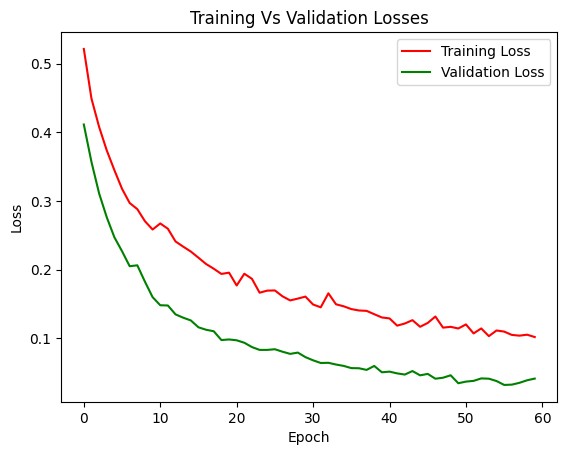

In [ ]:
#Plot the train & validation losses
plt.figure(1)
plt.title("Training Vs Validation Losses")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epoch_counter_train,train_loss,color = 'r', label="Training Loss")
plt.plot(epoch_counter_val,val_loss,color = 'g', label="Validation Loss")
plt.legend()
plt.show()

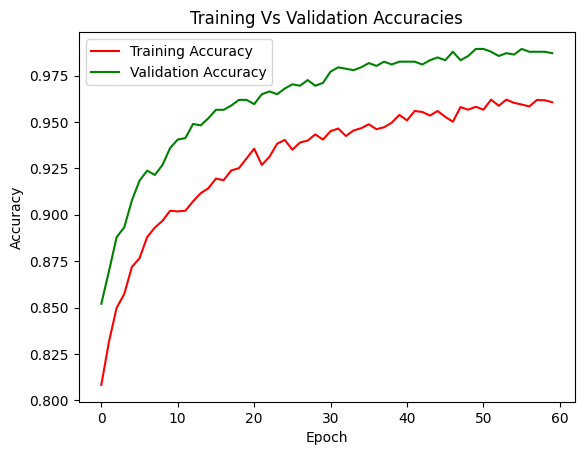

In [ ]:
import torch
import matplotlib.pyplot as plt

# Convert the lists to PyTorch tensors
train_acc_tensor = torch.tensor(train_acc)
val_acc_tensor = torch.tensor(val_acc)

# Plot the accuracies in train & validation
plt.figure(2)
plt.title("Training Vs Validation Accuracies")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(epoch_counter_train, train_acc_tensor.cpu().numpy(), color='r', label="Training Accuracy")
plt.plot(epoch_counter_val, val_acc_tensor.cpu().numpy(), color='g', label="Validation Accuracy")
plt.legend()
plt.show()


In [ ]:
#Class wise testing accuracy
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['Validating']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, predicted = torch.max(outputs, 1)
            point = (predicted == labels).squeeze()
            for j in range(len(labels)):
                label = labels[j]
                class_correct[label] += point[j].item()
                class_total[label] += 1

for i in range(4):
    print('Accuracy of %5s : %2d %%' % (
        class_names[i], 100 * class_correct[i] / class_total[i]))

Accuracy of glioma : 97 %
Accuracy of meningioma : 97 %
Accuracy of notumor : 100 %
Accuracy of pituitory : 99 %


In [ ]:
#Get the confusion matrix for testing data
confusion_matrix = cm.ConfusionMeter(4)
with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['Validating']):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, predicted = torch.max(outputs, 1)
        confusion_matrix.add(predicted, labels)
    print(confusion_matrix.conf)

def get_confusion_matrix():
  confusion_matrix = cm.ConfusionMeter(4)
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders['Validating']):
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model_ft(inputs)
      _, predicted

[[223   5   0   0]
 [  2 299   1   4]
 [  0   0 405   0]
 [  0   1   0 299]]


<Axes: >

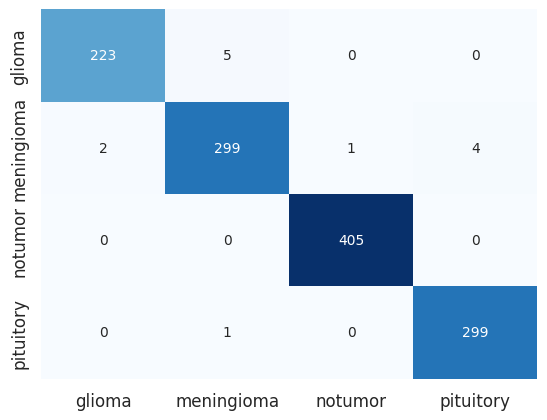

In [ ]:
#Confusion matrix as a heatmap
con_m = confusion_matrix.conf
df_con_m = pd.DataFrame(con_m, index= [i for i in class_names], columns = [i for i in class_names])
sn.set(font_scale= 1.1)
sn.heatmap(df_con_m, annot=True,fmt='g' ,  annot_kws={"size" : 10}, cbar = False, cmap="Blues")

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# function to evaluate model performance
def evaluate_model(model_ft, dataloader):
    model_ft.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model_ft(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print('Accuracy: {:.4f} Precision: {:.4f} Recall: {:.4f} F1 score: {:.4f}'.format(accuracy, precision, recall, f1))
evaluate_model(model_ft, dataloaders['Testing'])

Accuracy: 0.9893 Precision: 0.9893 Recall: 0.9893 F1 score: 0.9893


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models

# Define the device to be used
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_detect = models.vgg16(pretrained=True)
num_ftrs = model_ft.classifier[-1].in_features
model_detect.classifier.add_module


# Define the model architecture
model_ft = models.vgg19_bn(pretrained=True)
num_ftrs = model_ft.classifier[-1].in_features
model_ft.classifier[-1] = nn.Linear(num_ftrs, 4)
model_ft.classifier.add_module('output', nn.LogSoftmax(dim=1))

# Load the saved model state dict
saved_model = torch.load('/content/gdrive/MyDrive/Brain_Tumor_2.0/model/BTD_2.0.1-vgg16softmax', map_location=torch.device('cpu'))

# Load the saved model state dict into the model
model_ft.load_state_dict(saved_model)

# Move the model to the device
model_ft = model_ft.to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer with weight decay
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, weight_decay=0.0001)

# # Define the learning rate scheduler
# exp_lr_scheduler = lr_scheduler.Step

In [ ]:
import PIL.Image as Image

def check_image(filename, model_ft, device):
    model_ft.eval()
    image = Image.open(filename)
    image_tensor = data_transforms['Testing'](image).unsqueeze(0)
    image_tensor = image_tensor.to(device)
    output = model_ft(image_tensor)
    _, pred = torch.max(output, 1)
    return class_names[pred]
filename = '/content/gdrive/MyDrive/Brain_Tumor_2.0/Contour_dataset/Testing/meningioma_tumor/image(102).jpg'
predicted_class = check_image(filename, model_ft, device)
print(predicted_class)